# Random Walks en Multiplex de Aerolíneas

## Directorio

In [1]:
#Establecer directorio
cd("$(homedir())/Documents/UNAM/Tesis_Lic")

## Paquetes

Se importan todos los paquetes que se necesitarán para las funciones y visualizaciones del proyecto.

In [2]:
using StatsBase

#using NamedArrays
#using CSV
#using LightGraphs
#using DataFrames

In [3]:
using DelimitedFiles

In [4]:
using RandomNumbers.Xorshifts

In [5]:
using Plots

In [6]:
listita = data_names("data/aerolineas_matrices/")

UndefVarError: UndefVarError: data_names not defined

In [7]:
#listita = ["abc", "def", "ghi", "jkl", "mno", "pqr", "stu", "vwx", "yz"]

In [8]:
#for i in 1:9
#    nomb = string("hola","_yu_",listita[i])
#    println(nomb)
#end

In [9]:
#readdir("data/")

In [10]:
#aerolin = readdlm("data/lista_aerolineas.csv", ',')

## Funciones

### Importar datos

In [11]:
"""
    import_matrix(file::string)

Función que importa el archivo de la matriz de adyacencia de R.
"""
function import_matrix(arch::AbstractString)
    archivo_R = readdlm(arch, ',') 
    archivo_R = archivo_R[2:end, :]
    matriz = archivo_R[:, 2:end]
    nombre = convert(Array{Int64,2}, matriz)
    return nombre
end

import_matrix

### Nombres de datos

In [12]:
"""
    airport_names(M)

Función que obtiene un arreglo con los nombres de aeropuertos de la matriz
"""
function airport_names(arch::AbstractString)
    archivo_R = readdlm(arch, ',')
    columna = archivo_R[1, :]
    nombres = columna[2:end]
    return nombres
end

airport_names

### Grado

In [13]:
"""

    n_in_degree(M::Array{Int64,2}, n::Int64)

Función que obtiene el grado de entrada de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
n nodo a evaluar de tipo Int64

Resultado:
Grado de entrada del nodo n representado por un valor numérico de tipo Int64

Implementación

#### Ejemplos
"""
function n_in_degree(M::Array{Int64,2}, n::Int64)
    grado_entrada = sum(M[n, :])
end

n_in_degree

In [14]:
"""
in_degree(M)

Función que obtiene el grado de entrada de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de entrada de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function in_degree(M::Array)
    grados_entrada = sum(M, dims = 2)
end

in_degree

In [15]:
"""
    n_out_degree(M, n)

Función que obtiene el grado de salida de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
* n nodo a evaluar de tipo Int64

Resultado:
Grado de salida del nodo n representado por un valor numérico de tipo Int64

## Implementación

### Ejemplos
"""

function n_out_degree(M::Array{Int64,2}, n::Int64)
    grado_salida = sum(M[:, n])
end

n_out_degree (generic function with 1 method)

In [16]:
"""
    out_degree(M)

Función que obtiene el grado de salida de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de salida de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function out_degree(M::Array)
    grados_salida = sum(M, dims = 1)
end

out_degree

### Distribución de grado

In [17]:
"""
Función de distribución de grado de entrada
"""
function distrib_in_degree(M::Array)
    x = in_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_in_degree

In [18]:
"""
Función de distribución de grado de salida
"""
function distrib_out_degree(M::Array)
    x = out_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_out_degree

In [19]:
function plot_distrib(M::Array, tipo::String, titulo::String, color::String)
    
    pyplot()
    
    if tipo == "in"
        distribucion = distrib_in_degree(M::Array)
    elseif tipo == "out"
        distribucion = distrib_out_degree(M::Array)
    end
    distribucion
    #@show distribucion
    graph = bar(distribucion, fillcolor = color, markersize = 3, linealpha = 0.5, 
    title = titulo, 
    xlabel = "Grado", 
    ylabel = "Frecuencia",
    xlims = (-10,300), #obtener límites
    ylims = (-10,1000)) #obtener límites
end

plot_distrib (generic function with 1 method)

### Vecinos

In [20]:
"""
    neighbors(M::Array{Int64,2})

Función que obtiene un conjunto de arreglos con los vecinos de cada nodo.
"""
function neighbors(M::Array{Int64,2})
    
    nodos = size(M, 1) #aeropuertos
    vecindades = []
    
    for i in 1:nodos
        vecinos = findall(x -> x != 0, M[i, :])
        push!(vecindades, vecinos)
    end
    vecindades
end

neighbors

### Random walks

In [21]:
"""

    r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)

La función r_walks tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
f, nodo inicial de tipo Int64
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz, el cual tiene igual probabilidad de avanzar 
hacia cualquiera de sus vecinos.
Regresa un arreglo que contiene todas las trayectorias que tomó el caminante aleatorio.
"""
function r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)
    
    paths = zeros(Int64, (iter, steps + 1))
    s = f
    seed = 1
    vecindades = neighbors(M)

    for i in 1:iter
        paths[i, 1] = f
        
        for p in 1:steps 
            vecindad = vecindades[s]
            
            if vecindad == []
                break
            else
                a = sample(Xoroshiro128Plus(seed), vecindad) 
                paths[i, p + 1] = a
                s = a
                seed += 1
            end
            
        end
        s = f
        
    end
    
    return paths 
end

r_walks

In [22]:
"""

    random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64)


La función random_walk tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz con igual probabilidad de avanzar 
hacia cualquiera de sus vecinos. Esta función recorre todos los nodos de la red como
nodos iniciales y sobre ellos itera para obtener el número de caminos que se le pidió.
Regresa un arreglo que contiene arreglos asociados a todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64) 
    random_walks = []
    nodos = size(M, 1)
    for f in 1:nodos #aeropuertos
        paths = r_walks(M, f, steps, iter)
        push!(random_walks, paths)
    end
    random_walks
end

random_walk

### Longitud de caminatas

In [23]:
"""
    walk_length(W)
La función walk_length tiene como parámetros:
RW, arreglo de arreglos de tipo Array{Any,1} que corresponde al arreglo de caminatas aleatorias.
La función regresa un arreglo de arreglos que contiene las longitudes de todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function walk_length(W)
    
    longitudes = Array[]
    
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #Es el número de iteraciones
    longitud = zeros(Int64, s)
    
    for i in 1:v
        
        for j in 1:s
               
            longitud[j] = findlast(x -> x != 0, W[i][j, :])
            
        end
         push!(longitudes, longitud)
        
        longitud = zeros(Int64, s)
    end
    return longitudes
        
end

walk_length

In [24]:
"""
    walk_av_length(W)
La función walk_av_length tiene como parámetro W, que es un arreglo de arreglos (que se puede obtener de la 
función walk_length). 
Regresa un arreglo con entradas correspondientes al promedio de las longitudes de 
las caminatas aleatorias para cada nodo de inicio antes de caer en un nodo con grado de salida 0.
"""
function walk_av_length(W) #Llamar a función
    
    proms = []
    wlength = walk_length(W)
    
    for i in 1:length(wlength)
        av = mean(wlength[i])
        push!(proms, av)
    end
    proms
end

walk_av_length

In [25]:
"""
    plot_walk_av_length(W)
Función que grafica (scatter plot) del promedio por nodo inicial de caminatas
"""
function plot_walk_av_length(W)
pyplot()
    wal = walk_av_length(W)
    
    scatter(wal, 
        color = "#0f87bf",
        alpha = 0.8, 
        title ="Multiplex", 
        xlabel ="Nodo inicial", 
        ylabel ="Promedio long.")
end

plot_walk_av_length

In [26]:
"""
    walk_layer_length(W)
Función que saca el promedio de longitud de caminata en la capa
"""
function walk_layer_length(W)
    
    x = walk_av_length(W)
    av = mean(x)
    
    return av
end

walk_layer_length

### Nodos/aeropuertos visitados

In [27]:
"""
    visited_vertices(W)
La función caminos tiene como parámetro W que es un arreglo de arreglos.
Regresa los nodos diferentes a los que llega el caminante.
"""
function visited_vertices(W)
    
    cobert = []
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos, no necesario
    #visit = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    visit = []
    
    for i in 1:v        
        for j in 1:s
            u = unique(W[i][j, :])
            push!(visit, u)
        end
        
        push!(cobert, visit)
        visit = []
    end
    
    return cobert
end

visited_vertices

### Frecuencia de visitas

In [28]:
"""
    freq_vertices_visits(W::Array)

Función que hace un diccionario con frecuencias de visitas
"""
function freq_vertices_visits(W::Array)
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    #for i = n
    for i in 1:nodos #corro por todos los nodos
        for j in 1:iter #corro por las iteraciones
            diccionario = countmap(W[i][j, :]) #hago diccionario de freqs de cada caminata
            push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
        end
        
        diccionario = 0
    end
    return dicc
end

freq_vertices_visits

In [29]:
"""
    distrib_vertices_visits(W)

Función que crea un arreglo de arreglos con la distribución de frecuencia de visitas
"""
function distrib_vertices_visits(W)
    
    x = freq_vertices_visits(W) #diccionario de frecuencias
    l = length(W)
    f = 0
    frec_total = [] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, l+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:l+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, l+1)
        
    end
    
    return frec_total
end

distrib_vertices_visits

In [30]:
"""
    plot_visit_freq(W)

Función que hace un heatmap de nodos en los que cae, cada renglón corresponde a una caminata
"""
function plot_visit_freq(W)
    
    pyplot()
    x = distrib_vertices_visits(W)
    h = transpose(hcat(x...))

    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(x)]
    z = h
    heatmap(xs, ys, z, aspect_ratio=1)
end

plot_visit_freq

In [31]:
#plot_visit_freq(rw)

In [32]:
"""
    freq_vertex_visits(W::Array, n)

Función que hace un diccionario con frecuencias para un nodo inicial
"""
function freq_vertex_visits(W::Array, n) #puede ser más eficiente llamando la función anterior sin nodo
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    for j in 1:iter #corro por las iteraciones
          
        diccionario = countmap(W[n][j, :]) #hago diccionario de freqs de cada caminata
          
        push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
          
    end
    
    return dicc
end

freq_vertex_visits

In [33]:
"""
    distrib_vertex_visits(W, n)

Función que crea un arreglo de arreglos con la distribución de frecuencias de visitas de un nodo inicial
"""
function distrib_vertex_visits(W, n)
    
    x = freq_vertex_visits(W, n) #diccionario de frecuencias
    nodos = length(W)
    f = 0
    frec_total = [] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, nodos+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:nodos+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, nodos+1)
        
    end
    
    return frec_total
end

distrib_vertex_visits

In [34]:
"""
    plot_visit_freq_vertex(W, n)

Función que hace un heatmap de los nodos en los que cae, cada renglón corresponde a una caminata 
con cierto nodo inicial n.
"""
function plot_visit_freq_vertex(W, n)
    
    pyplot()
    x = distrib_vertex_visits(W, n)
    h = transpose(hcat(x...))
    pasos = size(W[1],2)-1

    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(x)]
    z = h
    heatmap(xs, ys, z, aspect_ratio = 1, clims = (0, pasos))
end

plot_visit_freq_vertex

In [35]:
"""
    distrib_av_visits(W::Array)

Función que hace una distribución de visitas por nodo inicial y muestra todos los nodos iniciales
"""
function distrib_av_visits(W::Array) 
    
    nodos = length(W) #número de nodos
    iteracion = size(W[1],1)
    dicc = zeros(Float64, nodos, nodos+1) #matriz de ceros (nodos x nodos+1)
    
    for i in 1:nodos
        conteos = counts(W[i], 0:nodos)/iteracion #hago diccionario de freqs de cada caminata
        @show conteos
        dicc[i, :] = conteos 
    end

    dicc
end

distrib_av_visits

In [36]:
"""
    plot_freq_av_visits(W::Array)

Función que crea un diccionario con frecuencias por nodo inicial y muestra todos
"""
function plot_freq_av_visits(W::Array)
    
    pyplot()
    x = distrib_av_visits(W)
    
    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(W)]
    z = x
    heatmap(xs, ys, z, aspect_ratio = 1, clims = (0, maximum(x)))
end

plot_freq_av_visits

### Cobertura

In [37]:
"""
    coverage(W)
La función cobertura tiene como parámetro W que es un arreglo de arreglos.
Regresa el número de nodos diferentes a los que llega el caminante.
"""
function coverage(W) 
    
    cobert = []
    
    v = length(W) #tamaño de la matriz, número de nodos
    x = visited_vertices(W)
    s = size(x[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    longz = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            l = length(x[i][j])
            longz[j] = l
        end
        push!(cobert, longz)
        longz = zeros(Int64, s)
    end
    return cobert
end

coverage

In [38]:
"""
    vertex_coverage(W)
Da el promedio de cobertura la caminata por nodo inicial. 
"""
function vertex_coverage(W) #Esta es la importante
    
    longitud = []
    x = coverage(W)
    
    for i in 1:length(x)
        l = mean(x[i])
        push!(longitud, l)
    end
    longitud
end

vertex_coverage

In [39]:
"""
    layer_coverage(W)

Da el promedio de la longitud de las caminatas para todos los nodos, como un número.
"""
function layer_coverage(W)
    x = vertex_coverage(W)
    promedio = mean(x)
    return promedio
end

layer_coverage

### Máximos y mínimos de longitud

In [40]:
"""
    max_length(W)
Da la longitud máxima de cada iteración de cada nodo inicial.
"""
function max_length(W)
    max = []
    x = coverage(W)
    for i in 1:length(x)
        m = maximum(x[i])
        push!(max, m)
    end
    max
end

max_length

In [41]:
"""
    Max_length(W)
Da la longitud máxima total.
"""
function Max_length(W)
    x = max_length(W)
    m = maximum(x)
    return m
end

Max_length

In [42]:
"""
    av_max_length(W)
Regresa el promedio de la longitud máxima de cada nodo inicial.
"""
function av_max_length(W)
    x = max_length(W)
    prom = mean(x)
    return prom
end

av_max_length

In [43]:
"""
    min_length(W)
Da la longitud mínima de cada iteración de cada nodo inicial.
"""
function min_length(W)
    min = []
    x = coverage(W)
    for i in 1:length(x)
        m = minimum(x[i])
        push!(min, m)
    end
    min
end

min_length

In [44]:
"""
    Min_length(W)
Da la longitud mínima total.
"""
function Min_length(W)
    x = min_length(W)
    m = minimum(x)
    return m
end

Min_length

In [45]:
"""
    av_min_length(W)
Regresa el promedio de la longitud mínima de cada nodo inicial.
"""
function av_min_length(W)
    x = min_length(W)
    prom = mean(x)
    return prom
end

av_min_length

### Endpoints

In [46]:
"""
    endpoints(W)

Regresa un arreglo de arreglos que contiene los nodos en los que cae cada caminata y ya no puede salir.
"""
function endpoints(W) 
    x = visited_vertices(W)
    atractores = [] #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos +1
    atract = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            if x[i][j, :][end][end] == 0
                at = x[i][j, :][end][end - 1]
                atract[j] = at
            else
                atract[j] = 0
            end
        end
        push!(atractores, atract)
        atract = zeros(Int64, s)
    end
    return atractores
end

endpoints

In [47]:
"""
    av_vertex_endpoints(W)
Función que calcula el promedio de endpoints por nodo
"""
function av_vertex_endpoints(W) 
    
    x = endpoints(W)
    atractores_prom = [] #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos

    for i in 1:v        
        av = mean(x[i])
        push!(atractores_prom, av)
    end
    atractores_prom
end

av_vertex_endpoints

### Distribución de frecuencia de endpoints

In [48]:
"""
    freq_endpoints(W)
Función que da un diccionario con frecuencias
"""
function freq_endpoints(W)
    freqs = []
    x = endpoints(W)
    v = length(W)
    
    for i in 1:v
        frec = countmap(x[i])
        push!(freqs, frec)
    end
    freqs
end

freq_endpoints

In [49]:
"""
    distrib_endpoints(W)
Función que saca la distribución de los atractores para toda la capa
"""
function distrib_endpoints(W)
    x = freq_endpoints(W)
    frec_total = zeros(Int64, length(W))
    frec_nodo = zeros(Int64, length(W))

    for i in 1:length(W)
        for j in 1:length(W)
            frec_nodo[j] = get(x[i], j, 0)
        end
        frec_total += frec_nodo
    end
    
    return frec_total
end

distrib_endpoints

## Datos


### Multiplex Global

In [50]:
lista_aerolineas = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/lista_aerolineas.csv", ',')
airline_code = lista_aerolineas[2]

"2B"

In [51]:
aerolinea_matriz = string(airline_code, "_matriz_du.csv")
multiplex = import_matrix("data/aerolineas_matrices/$aerolinea_matriz")

17×17 Array{Int64,2}:
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  1
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  1  1  1  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0

In [52]:
nombres_multiplex = airport_names("data/aerolineas_matrices/$aerolinea_matriz")

17-element Array{Any,1}:
 "AER"
 "ASF"
 "CEK"
 "DME"
 "EGO"
 "GYD"
 "KGD"
 "KZN"
 "LED"
 "MRV"
 "NBC"
 "NJC"
 "NUX"
 "OVB"
 "SVX"
 "TGK"
 "UUA"

## Distribuciones de grado

### Multiplex Global

#### Grado de entrada

In [53]:
in_degree_multiplex = in_degree(multiplex)

17×1 Array{Int64,2}:
 1
 2
 2
 4
 2
 1
 1
 7
 3
 1
 4
 2
 1
 2
 5
 1
 3

In [54]:
distrib_in_multiplex = distrib_in_degree(multiplex)

7-element Array{Int64,1}:
 6
 5
 2
 2
 1
 0
 1

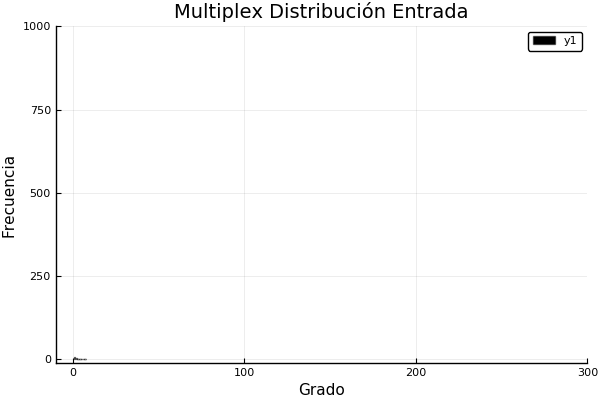

In [55]:
in_M = plot_distrib(multiplex, "in", "Multiplex Distribución Entrada", "black")

#### Grado de salida

In [56]:
out_degree_multiplex = out_degree(multiplex)

1×17 Array{Int64,2}:
 1  2  2  4  2  1  1  7  3  1  4  2  1  2  5  1  3

In [57]:
distrib_out_multiplex = distrib_out_degree(multiplex)

7-element Array{Int64,1}:
 6
 5
 2
 2
 1
 0
 1

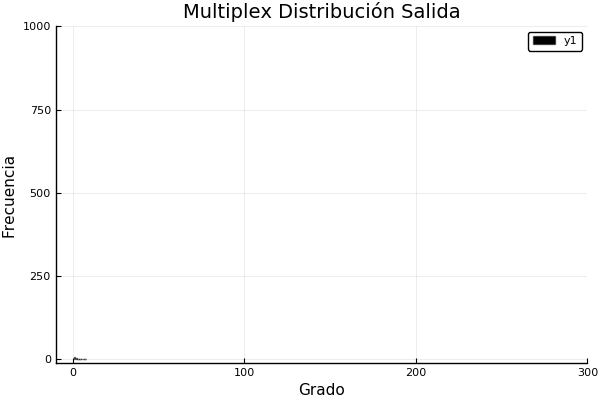

In [58]:
out_M = plot_distrib(multiplex, "out", "Multiplex Distribución Salida", "black")

## Vecinos

### Multiplex global

In [59]:
vecinos_M = @time neighbors(multiplex)

  0.125462 seconds (205.19 k allocations: 9.850 MiB)


17-element Array{Any,1}:
 [8]                   
 [8, 10]               
 [8, 14]               
 [8, 11, 16, 17]       
 [7, 8]                
 [11]                  
 [5]                   
 [1, 2, 3, 4, 5, 9, 15]
 [8, 11, 17]           
 [2]                   
 [4, 6, 9, 15]         
 [15, 17]              
 [15]                  
 [3, 15]               
 [8, 11, 12, 13, 14]   
 [4]                   
 [4, 9, 12]            

## Caminatas aleatorias

### Multiplex

In [60]:
caminata_M = @time random_walk(multiplex, 25, 5) #nuevo

  0.205079 seconds (418.20 k allocations: 21.407 MiB, 5.89% gc time)


17-element Array{Any,1}:
 [1 8 … 8 1; 1 8 … 4 8; … ; 1 8 … 4 8; 1 8 … 14 3]           
 [2 10 … 15 12; 2 10 … 4 8; … ; 2 10 … 4 8; 2 10 … 9 17]     
 [3 14 … 15 12; 3 14 … 4 8; … ; 3 14 … 4 8; 3 14 … 14 3]     
 [4 11 … 15 12; 4 11 … 4 8; … ; 4 11 … 4 8; 4 11 … 14 3]     
 [5 8 … 8 1; 5 8 … 4 8; … ; 5 8 … 4 8; 5 8 … 14 3]           
 [6 11 … 15 12; 6 11 … 4 8; … ; 6 11 … 4 8; 6 11 … 14 3]     
 [7 5 … 8 1; 7 5 … 8 9; … ; 7 5 … 14 3; 7 5 … 14 3]          
 [8 9 … 8 1; 8 9 … 8 9; … ; 8 4 … 14 3; 8 5 … 14 3]          
 [9 17 … 15 12; 9 8 … 4 8; … ; 9 11 … 4 8; 9 8 … 14 3]       
 [10 2 … 8 1; 10 2 … 8 9; … ; 10 2 … 14 3; 10 2 … 14 3]      
 [11 6 … 8 1; 11 6 … 4 8; … ; 11 6 … 14 3; 11 6 … 14 3]      
 [12 17 … 15 12; 12 17 … 4 8; … ; 12 17 … 14 3; 12 17 … 14 3]
 [13 15 … 8 1; 13 15 … 4 8; … ; 13 15 … 14 3; 13 15 … 14 3]  
 [14 15 … 8 1; 14 15 … 4 8; … ; 14 15 … 14 3; 14 15 … 14 3]  
 [15 11 … 15 12; 15 13 … 4 8; … ; 15 11 … 4 8; 15 13 … 14 3] 
 [16 4 … 8 1; 16 4 … 8 9; … ; 16 4 … 14 3; 16

## Longitud de todas las iteraciones de caminatas 

In [61]:
li_M = @time walk_length(caminata_M)

  0.130778 seconds (248.88 k allocations: 12.128 MiB, 10.16% gc time)


17-element Array{Array,1}:
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]

## Longitud promedio de las iteraciones de caminatas de cada nodo inicial

In [62]:
lpn_M = @time walk_av_length(caminata_M)

  0.113942 seconds (163.23 k allocations: 8.203 MiB, 15.73% gc time)


17-element Array{Any,1}:
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0

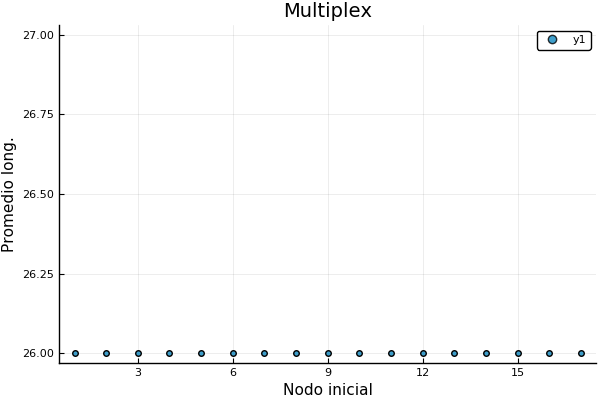

In [63]:
pyplot()
d_lpn_M = scatter(lpn_M, color="#0f87bf",alpha=0.8, 
    title="Multiplex", 
    xlabel="Nodo inicial", 
    ylabel="Promedio long.")

## Longitud promedio de caminatas por capa

In [64]:
wl_M = @time walk_layer_length(caminata_M)

  0.093665 seconds (82.55 k allocations: 4.410 MiB)


26.0

## Nodos visitados específicamente

In [65]:
#No lo corro ahora para que no se tarde tanto
nv_M = @time visited_vertices(caminata_M)

  0.103719 seconds (50.92 k allocations: 2.545 MiB)


17-element Array{Any,1}:
 Any[[1, 8, 4, 17, 12, 15, 11, 9, 2, 5, 7], [1, 8, 4, 17, 11, 9, 15, 3, 14], [1, 8, 2, 10, 5, 7, 15, 12, 17, 9, 11, 4], [1, 8, 2, 10, 15, 14, 13, 3, 9, 17, 4], [1, 8, 9, 17, 12, 15, 4, 2, 16, 3, 14]]     
 Any[[2, 10, 8, 3, 9, 4, 17, 14, 15, 12], [2, 10, 8, 1, 4, 15, 3, 14], [2, 10, 8, 5, 7, 1, 15, 12, 17, 9, 11, 4], [2, 10, 8, 15, 14, 13, 3, 9, 17, 4], [2, 10, 8, 9, 17, 4, 1, 3, 14, 15]]                  
 Any[[3, 14, 15, 8, 9, 2, 4, 17, 12], [3, 14, 8, 1, 4, 15], [3, 14, 15, 12, 17, 9, 11, 4, 8, 16, 5], [3, 14, 8, 15, 13, 9, 17, 4], [3, 14, 15, 13, 12, 17, 9, 8, 2, 4, 16]]                                 
 Any[[4, 11, 9, 8, 15, 3, 14, 2, 17, 12], [4, 11, 9, 8, 1, 15, 3, 14], [4, 11, 9, 8, 5, 2, 7, 1, 15, 12, 17], [4, 11, 9, 8, 16, 2, 6, 17], [4, 11, 9, 17, 12, 15, 8, 2, 16, 3, 14]]                         
 Any[[5, 8, 4, 17, 12, 15, 11, 9, 2, 7, 1], [5, 8, 4, 17, 11, 9, 1, 15, 3, 14], [5, 8, 2, 10, 7, 1, 15, 12, 17, 9, 11, 4], [5, 8, 2, 10, 15, 14, 13, 3, 9, 

In [66]:
#Falta función de aeropuertos específicos

## Frecuencia de visitas

In [67]:
freq_visit_M = @time freq_vertices_visits(caminata_M)

  1.355883 seconds (3.11 M allocations: 164.954 MiB, 16.49% gc time)


85-element Array{Any,1}:
 Dict(2=>1,11=>2,7=>2,9=>2,17=>4,8=>4,4=>3,5=>3,15=>1,12=>2…) 
 Dict(4=>4,9=>1,14=>4,3=>5,17=>1,11=>1,8=>7,15=>1,1=>2)       
 Dict(2=>3,11=>1,7=>3,9=>1,10=>2,17=>1,8=>5,4=>1,5=>5,15=>1…) 
 Dict(2=>2,9=>1,10=>1,17=>1,8=>4,4=>1,3=>4,13=>1,14=>6,15=>4…)
 Dict(2=>1,16=>1,9=>2,17=>2,8=>6,4=>3,3=>4,14=>3,15=>2,12=>1…)
 Dict(4=>1,9=>2,10=>4,14=>2,2=>6,3=>3,17=>1,8=>5,15=>1,12=>1…)
 Dict(4=>2,14=>4,10=>3,2=>4,3=>5,8=>6,15=>1,1=>1)             
 Dict(2=>4,11=>1,7=>3,9=>1,10=>3,17=>1,8=>4,4=>1,5=>5,15=>1…) 
 Dict(4=>1,9=>1,10=>2,13=>1,2=>3,3=>4,14=>6,17=>1,8=>3,15=>4…)
 Dict(4=>1,9=>3,10=>2,14=>3,2=>4,3=>3,17=>3,8=>5,15=>1,1=>1…) 
 Dict(4=>1,9=>2,14=>6,2=>1,3=>7,17=>1,8=>5,15=>2,12=>1)       
 Dict(4=>2,14=>7,3=>9,8=>6,15=>1,1=>1)                        
 Dict(16=>1,11=>2,9=>2,17=>1,8=>4,4=>3,3=>6,5=>1,14=>4,15=>1…)
 ⋮                                                            
 Dict(4=>5,9=>5,2=>1,16=>1,17=>1,11=>6,8=>5,15=>1,6=>1)       
 Dict(2=>1,16=>1,9=>1,17=>4,8=

In [68]:
distrib_visit_M = @time distrib_vertices_visits(caminata_M)

  0.034752 seconds (23.67 k allocations: 7.299 MiB)


85-element Array{Any,1}:
 [0, 2, 1, 0, 3, 3, 0, 2, 4, 2, 0, 2, 2, 0, 0, 1, 0, 4]
 [0, 2, 0, 5, 4, 0, 0, 0, 7, 1, 0, 1, 0, 0, 4, 1, 0, 1]
 [0, 2, 3, 0, 1, 5, 0, 3, 5, 1, 2, 1, 1, 0, 0, 1, 0, 1]
 [0, 1, 2, 4, 1, 0, 0, 0, 4, 1, 1, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 1, 4, 3, 0, 0, 0, 6, 2, 0, 0, 1, 0, 3, 2, 1, 2]
 [0, 0, 6, 3, 1, 0, 0, 0, 5, 2, 4, 0, 1, 0, 2, 1, 0, 1]
 [0, 1, 4, 5, 2, 0, 0, 0, 6, 0, 3, 0, 0, 0, 4, 1, 0, 0]
 [0, 1, 4, 0, 1, 5, 0, 3, 4, 1, 3, 1, 1, 0, 0, 1, 0, 1]
 [0, 0, 3, 4, 1, 0, 0, 0, 3, 1, 2, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 4, 3, 1, 0, 0, 0, 5, 3, 2, 0, 0, 0, 3, 1, 0, 3]
 [0, 0, 1, 7, 1, 0, 0, 0, 5, 2, 0, 0, 1, 0, 6, 2, 0, 1]
 [0, 1, 0, 9, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 7, 1, 0, 0]
 [0, 0, 0, 6, 3, 1, 0, 0, 4, 2, 0, 2, 1, 0, 4, 1, 1, 1]
 ⋮                                                     
 [0, 0, 1, 0, 5, 0, 1, 0, 5, 5, 0, 6, 0, 0, 0, 1, 1, 1]
 [0, 0, 1, 4, 3, 0, 0, 0, 3, 1, 0, 0, 3, 1, 3, 2, 1, 4]
 [0, 2, 1, 0, 3, 6, 0, 3, 7, 1, 0, 0, 0, 0, 0, 0, 2, 1]
 [0, 0, 1, 3, 2, 5, 0, 

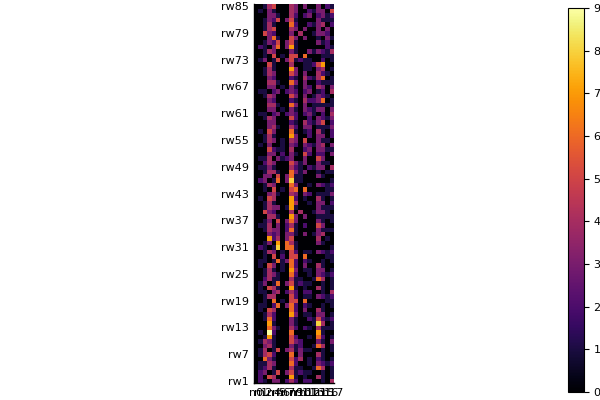

In [69]:
plot_visit_freq(caminata_M)

In [70]:
freq_vertex_visits(caminata_M, 1)

5-element Array{Any,1}:
 Dict(2=>1,11=>2,7=>2,9=>2,17=>4,8=>4,4=>3,5=>3,15=>1,12=>2…) 
 Dict(4=>4,9=>1,14=>4,3=>5,17=>1,11=>1,8=>7,15=>1,1=>2)       
 Dict(2=>3,11=>1,7=>3,9=>1,10=>2,17=>1,8=>5,4=>1,5=>5,15=>1…) 
 Dict(2=>2,9=>1,10=>1,17=>1,8=>4,4=>1,3=>4,13=>1,14=>6,15=>4…)
 Dict(2=>1,16=>1,9=>2,17=>2,8=>6,4=>3,3=>4,14=>3,15=>2,12=>1…)

In [71]:
distrib_vertex_visits(caminata_M, 1)

5-element Array{Any,1}:
 [0, 2, 1, 0, 3, 3, 0, 2, 4, 2, 0, 2, 2, 0, 0, 1, 0, 4]
 [0, 2, 0, 5, 4, 0, 0, 0, 7, 1, 0, 1, 0, 0, 4, 1, 0, 1]
 [0, 2, 3, 0, 1, 5, 0, 3, 5, 1, 2, 1, 1, 0, 0, 1, 0, 1]
 [0, 1, 2, 4, 1, 0, 0, 0, 4, 1, 1, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 1, 4, 3, 0, 0, 0, 6, 2, 0, 0, 1, 0, 3, 2, 1, 2]

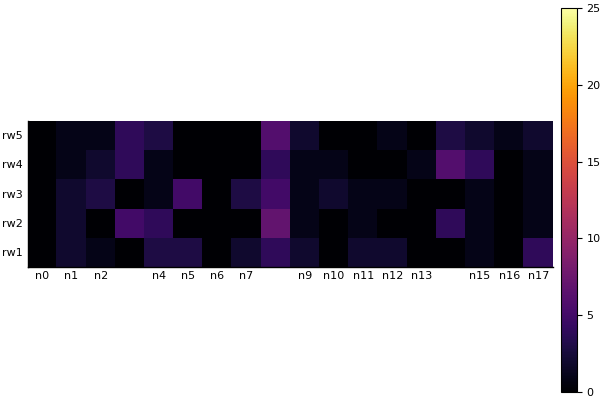

In [72]:
plot_visit_freq_vertex(caminata_M, 1)

In [73]:
distrib_prom_M = @time distrib_av_visits(caminata_M)

conteos = [0.0, 1.6, 1.4, 2.6, 2.4, 1.6, 0.0, 1.0, 5.2, 1.4, 0.6, 0.8, 0.8, 0.2, 2.6, 1.8, 0.2, 1.8]
conteos = [0.0, 0.6, 4.2, 3.0, 1.2, 1.0, 0.0, 0.6, 4.6, 1.4, 2.8, 0.2, 0.4, 0.2, 3.0, 1.6, 0.0, 1.2]
conteos = [0.0, 0.2, 0.4, 7.0, 1.8, 0.2, 0.0, 0.0, 4.2, 1.2, 0.0, 0.4, 0.8, 0.4, 6.0, 2.0, 0.4, 1.0]
conteos = [0.0, 0.4, 0.8, 2.6, 3.6, 1.2, 0.2, 0.6, 5.8, 2.8, 0.0, 2.6, 0.6, 0.0, 2.0, 1.4, 0.4, 1.0]
conteos = [0.0, 0.6, 1.4, 2.6, 2.4, 2.6, 0.0, 1.0, 5.2, 1.4, 0.6, 0.8, 0.8, 0.2, 2.6, 1.8, 0.2, 1.8]
conteos = [0.0, 0.4, 0.8, 2.6, 2.6, 1.2, 1.2, 0.6, 5.8, 2.8, 0.0, 2.6, 0.6, 0.0, 2.0, 1.4, 0.4, 1.0]
conteos = [0.0, 0.4, 0.6, 3.4, 1.6, 5.0, 0.0, 4.0, 4.8, 0.8, 0.0, 0.6, 0.0, 0.2, 2.6, 1.2, 0.4, 0.4]
conteos = [0.0, 0.2, 1.6, 3.6, 1.8, 2.4, 0.0, 1.2, 5.6, 1.6, 0.8, 1.0, 0.0, 0.2, 3.0, 1.8, 0.6, 0.6]
conteos = [0.0, 0.2, 0.6, 3.2, 3.4, 0.2, 0.2, 0.0, 5.8, 3.6, 0.0, 2.0, 0.8, 0.0, 2.2, 1.4, 0.6, 1.8]
conteos = [0.0, 0.6, 2.0, 2.8, 1.8, 2.4, 0.0, 1.2, 5.8, 2.0, 1.0, 1.2, 0.4, 0.2, 2.0, 1.0, 

17×18 Array{Float64,2}:
 0.0  1.6  1.4  2.6  2.4  1.6  0.0  1.0  …  0.8  0.8  0.2  2.6  1.8  0.2  1.8
 0.0  0.6  4.2  3.0  1.2  1.0  0.0  0.6     0.2  0.4  0.2  3.0  1.6  0.0  1.2
 0.0  0.2  0.4  7.0  1.8  0.2  0.0  0.0     0.4  0.8  0.4  6.0  2.0  0.4  1.0
 0.0  0.4  0.8  2.6  3.6  1.2  0.2  0.6     2.6  0.6  0.0  2.0  1.4  0.4  1.0
 0.0  0.6  1.4  2.6  2.4  2.6  0.0  1.0     0.8  0.8  0.2  2.6  1.8  0.2  1.8
 0.0  0.4  0.8  2.6  2.6  1.2  1.2  0.6  …  2.6  0.6  0.0  2.0  1.4  0.4  1.0
 0.0  0.4  0.6  3.4  1.6  5.0  0.0  4.0     0.6  0.0  0.2  2.6  1.2  0.4  0.4
 0.0  0.2  1.6  3.6  1.8  2.4  0.0  1.2     1.0  0.0  0.2  3.0  1.8  0.6  0.6
 0.0  0.2  0.6  3.2  3.4  0.2  0.2  0.0     2.0  0.8  0.0  2.2  1.4  0.6  1.8
 0.0  0.6  2.0  2.8  1.8  2.4  0.0  1.2     1.2  0.4  0.2  2.0  1.0  0.4  1.2
 0.0  0.4  0.4  3.8  1.6  0.8  1.2  0.4  …  3.6  1.4  0.2  3.2  2.6  0.4  1.4
 0.0  0.2  0.4  3.8  2.8  0.2  0.0  0.0     1.6  2.2  0.2  2.8  2.4  0.4  2.4
 0.0  0.2  0.4  2.8  2.8  0.8  0.2  0.4 

conteos = [0.0, 1.6, 1.4, 2.6, 2.4, 1.6, 0.0, 1.0, 5.2, 1.4, 0.6, 0.8, 0.8, 0.2, 2.6, 1.8, 0.2, 1.8]
conteos = [0.0, 0.6, 4.2, 3.0, 1.2, 1.0, 0.0, 0.6, 4.6, 1.4, 2.8, 0.2, 0.4, 0.2, 3.0, 1.6, 0.0, 1.2]
conteos = [0.0, 0.2, 0.4, 7.0, 1.8, 0.2, 0.0, 0.0, 4.2, 1.2, 0.0, 0.4, 0.8, 0.4, 6.0, 2.0, 0.4, 1.0]
conteos = [0.0, 0.4, 0.8, 2.6, 3.6, 1.2, 0.2, 0.6, 5.8, 2.8, 0.0, 2.6, 0.6, 0.0, 2.0, 1.4, 0.4, 1.0]
conteos = [0.0, 0.6, 1.4, 2.6, 2.4, 2.6, 0.0, 1.0, 5.2, 1.4, 0.6, 0.8, 0.8, 0.2, 2.6, 1.8, 0.2, 1.8]
conteos = [0.0, 0.4, 0.8, 2.6, 2.6, 1.2, 1.2, 0.6, 5.8, 2.8, 0.0, 2.6, 0.6, 0.0, 2.0, 1.4, 0.4, 1.0]
conteos = [0.0, 0.4, 0.6, 3.4, 1.6, 5.0, 0.0, 4.0, 4.8, 0.8, 0.0, 0.6, 0.0, 0.2, 2.6, 1.2, 0.4, 0.4]
conteos = [0.0, 0.2, 1.6, 3.6, 1.8, 2.4, 0.0, 1.2, 5.6, 1.6, 0.8, 1.0, 0.0, 0.2, 3.0, 1.8, 0.6, 0.6]
conteos = [0.0, 0.2, 0.6, 3.2, 3.4, 0.2, 0.2, 0.0, 5.8, 3.6, 0.0, 2.0, 0.8, 0.0, 2.2, 1.4, 0.6, 1.8]
conteos = [0.0, 0.6, 2.0, 2.8, 1.8, 2.4, 0.0, 1.2, 5.8, 2.0, 1.0, 1.2, 0.4, 0.2, 2.0, 1.0, 

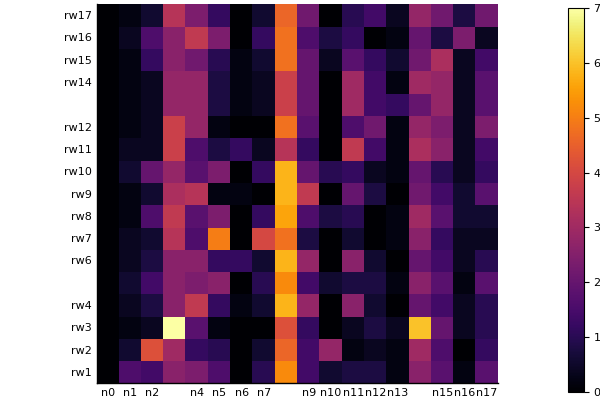

In [74]:
plot_freq_av_visits(caminata_M)

## Cobertura (nodos distintos)

In [75]:
cobi_M = @time coverage(caminata_M)

  0.044444 seconds (20.66 k allocations: 1.097 MiB)


17-element Array{Any,1}:
 [11, 9, 12, 11, 11] 
 [10, 8, 12, 10, 10] 
 [9, 6, 11, 8, 11]   
 [10, 8, 11, 8, 11]  
 [11, 10, 12, 11, 11]
 [11, 9, 12, 8, 12]  
 [8, 8, 7, 10, 11]   
 [10, 9, 10, 9, 11]  
 [9, 9, 11, 8, 10]   
 [9, 9, 11, 12, 10]  
 [10, 10, 11, 11, 10]
 [9, 10, 11, 10, 10] 
 [12, 11, 11, 10, 10]
 [12, 10, 10, 10, 9] 
 [10, 8, 12, 9, 11]  
 [9, 10, 9, 9, 8]    
 [10, 11, 11, 10, 9] 

## Cobertura promedio de las caminatas de cada aeropuerto inicial

In [76]:
cobs_M = @time vertex_coverage(caminata_M)

  0.025021 seconds (18.07 k allocations: 1016.092 KiB)


17-element Array{Any,1}:
 10.8
 10.0
  9.0
  9.6
 11.0
 10.4
  8.8
  9.8
  9.4
 10.2
 10.4
 10.0
 10.8
 10.2
 10.0
  9.0
 10.2

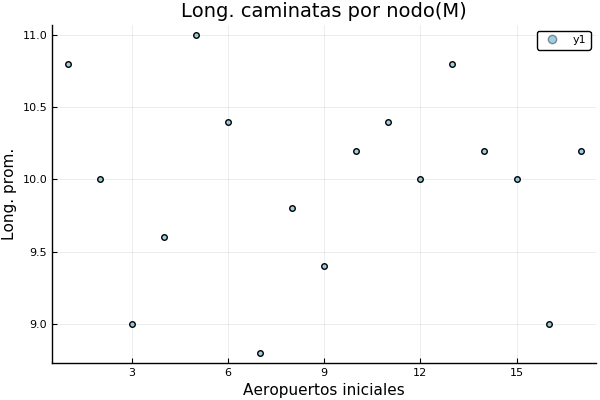

In [77]:
d_cobs_M = scatter(cobs_M, color="#0f87bf",alpha=0.4, 
    title="Long. caminatas por nodo(M)", 
    xlabel="Aeropuertos iniciales", 
    ylabel="Long. prom.")

## Cobertura promedio

In [78]:
cobp_M = @time layer_coverage(caminata_M)

  0.007973 seconds (2.23 k allocations: 188.630 KiB)


9.976470588235294

## Longitudes máximas de caminatas

In [79]:
lmax_M = @time max_length(caminata_M)

  0.064768 seconds (47.47 k allocations: 2.542 MiB)


17-element Array{Any,1}:
 12
 12
 11
 11
 12
 12
 11
 11
 11
 12
 11
 11
 12
 12
 12
 10
 11

In [80]:
lMax_M = @time Max_length(caminata_M)

  0.065413 seconds (34.30 k allocations: 1.891 MiB)


12

In [81]:
lavmax_M = @time av_max_length(caminata_M)

  0.011828 seconds (2.19 k allocations: 189.005 KiB)


11.411764705882353

## Longitudes mínimas de caminatas

In [82]:
lmin_M = @time min_length(caminata_M)

  0.028803 seconds (15.33 k allocations: 864.748 KiB)


17-element Array{Any,1}:
  9
  8
  6
  8
 10
  8
  7
  9
  8
  9
 10
  9
 10
  9
  8
  8
  9

In [83]:
lMin_M = @time Min_length(caminata_M)

  0.040412 seconds (32.89 k allocations: 1.813 MiB)


6

In [84]:
lavmin_M = @time av_min_length(caminata_M)

  0.004824 seconds (2.17 k allocations: 187.755 KiB)


8.529411764705882

## Endpoints

In [85]:
endpts_M = @time endpoints(caminata_M)

  0.086446 seconds (90.08 k allocations: 4.625 MiB)


17-element Array{Any,1}:
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]

In [86]:
av_endpts_M = @time av_vertex_endpoints(caminata_M)

  0.022240 seconds (15.56 k allocations: 876.866 KiB)


17-element Array{Any,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [87]:
distrib_endpts_M = @time distrib_endpoints(caminata_M)

  0.163786 seconds (272.28 k allocations: 13.456 MiB, 7.43% gc time)


17-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0